 ### Tasks to be Performed

1.Data sourcing and sentiment analysis

2.Building a recommendation system

3.Improving the recommendations using the sentiment analysis model

4.Deploying the end-to-end project with a user interface

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
# nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# import spellchecker
# from spellchecker import SpellChecker

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE

# Import pickle to save and load the model
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Import Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# import libraries for XGBoost classifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics.pairwise import pairwise_distances

from pprint import pprint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Load Data
df = pd.read_csv("/content/gdrive/My Drive/Colab/Capstone/sample30.csv")

In [ ]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


# Exploratory Data Analysis

In [ ]:
df.shape

(30000, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

## Observations
1.   There are many columns with NULL values which need to be handled.
2.   We may not require all the columns as a part of our models so we can inspect and remove them.


Data Description provided in problem statement.

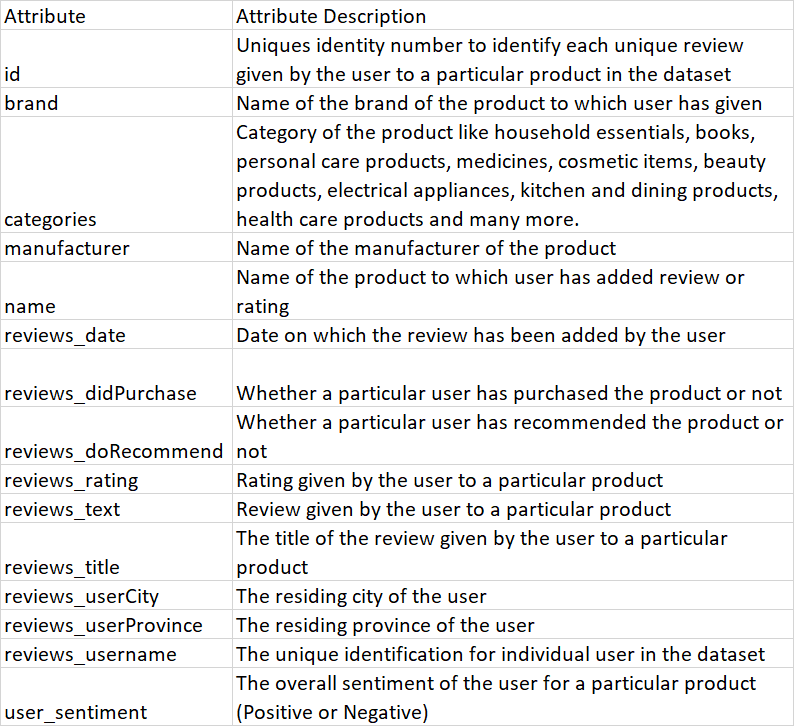

# Data Cleaning

## HandleNull Values

In [ ]:
# Get total number of NULL values and Percentage of the columns
null_count = df[df.columns[df.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df[df.columns[df.isna().any()]].isna().sum() * 100 / df.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

,Count,Percentage
reviews_userProvince,29830,99.433333
reviews_userCity,28071,93.570000
reviews_didPurchase,14068,46.893333
reviews_doRecommend,2570,8.566667
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


Observations:
1. reviews_userProvince and reviews_userCity have over 93% values NULL and are not useful for our analysis. So we will remove them from the dataset.
    
2. reviews_didPurchase column has over 46% NULL values. This field is not useful in building either Sentiment/Recommender system as well and hence will be removed.

In [ ]:
df_clean = df.copy()
df_clean.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase'], inplace=True)
df_clean.shape

(30000, 12)

In [ ]:
# Check NULLs again
null_count = df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum() * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data


,Count,Percentage
reviews_doRecommend,2570,8.566667
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


Check reviews_doRecommend column

In [ ]:
df_clean.reviews_doRecommend.value_counts(normalize=True)

True     0.943493
False    0.056507
Name: reviews_doRecommend, dtype: float64

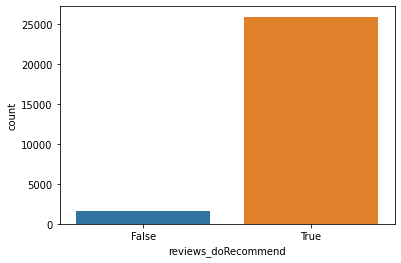

In [ ]:
sns.countplot(x = 'reviews_doRecommend', data = df_clean)
plt.show()

The distribution of this column value is quite skewed. So is not much helpful in modeling. Can be dropped

In [ ]:
df_clean.drop(columns=['reviews_doRecommend'], inplace=True)



In [ ]:
# Check NULLs again
null_count = df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum() * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data


,Count,Percentage
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


In [ ]:
# Handle null values in review_title
#This column has very less null values, so those records can be dropped
df_clean = df_clean[~ df_clean.reviews_title.isna() ]

In [ ]:
# Check NULLs again
null_count = df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum() * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

,Count,Percentage
manufacturer,141,0.472996
reviews_username,62,0.207984
reviews_date,46,0.154311
user_sentiment,1,0.003355


Column manufacturer and review_date are not needed for our recommender or sentiment models, so we could ignore them

In [ ]:
df_clean[ df_clean.user_sentiment.isna() ]

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,NaN


In [ ]:
df_clean.user_sentiment.value_counts()

Positive    26464
Negative     3345
Name: user_sentiment, dtype: int64

In [ ]:
#Since only one row is with null value, we can fill it with Positive
df_clean.user_sentiment.fillna("Positive", inplace= True)

In [ ]:
# Check NULLs again
null_count = df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum() * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

,Count,Percentage
manufacturer,141,0.472996
reviews_username,62,0.207984
reviews_date,46,0.154311


In [ ]:
# review_username is an user identification, so important. Since percentage is very less will remove those records

df_clean = df_clean[~df_clean.reviews_username.isna()]


In [ ]:
# Check NULLs again
null_count = df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_clean[df_clean.columns[df_clean.isna().any()]].isna().sum() * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

,Count,Percentage
manufacturer,141,0.473981
reviews_date,40,0.134463


Since we are not going to address these two columns, null handlig is done

In [ ]:
df_clean.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


##Analyze reviews_rating column

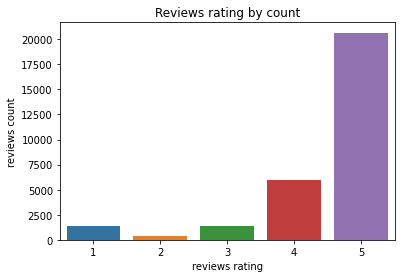

In [ ]:
sns.countplot(x = 'reviews_rating', data = df_clean).set(title="Reviews rating by count", xlabel="reviews rating", ylabel="reviews count")
plt.show()

Most of the ratings are on higher side, so we need to handle it


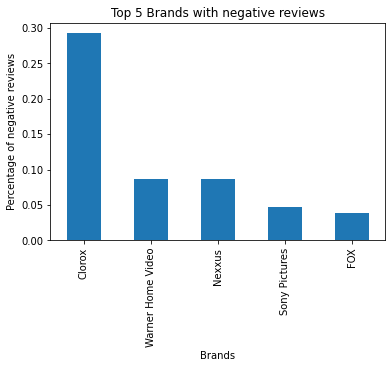

In [ ]:
# Brands with negative reviews
df_clean[ df_clean.user_sentiment == 'Negative' ].brand.value_counts(normalize=True, ascending=False).head(5).plot(kind='bar')
plt.title("Top 5 Brands with negative reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of negative reviews")
plt.show()

Clorox is the most nagatively rated product as nearly 30% of the negative reviews have been towards Clorox

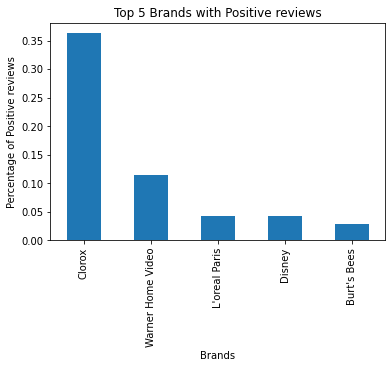

In [ ]:
# Brands with negative reviews
df_clean[ df_clean.user_sentiment == 'Positive' ].brand.value_counts(normalize=True, ascending=False).head(5).plot(kind='bar')
plt.title("Top 5 Brands with Positive reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of Positive reviews")
plt.show()

Clorox also has most positive reviews, almost 35%

In [ ]:
df_clean.brand.value_counts(normalize=True).head(5)

Clorox               0.355116
Warner Home Video    0.111739
Disney               0.040238
L'oreal Paris        0.039868
FOX                  0.029817
Name: brand, dtype: float64

Clorox has 35% of all the reviews so its being top negative and top Positive reviewed makes sense

## Analyze Reviews by date

In [ ]:
df_clean.reviews_date.dtype

dtype('O')

In [ ]:
df_clean['reviews_date'] = pd.to_datetime(df_clean['reviews_date'], errors='coerce')

In [ ]:
df_clean.reviews_date.dtype

datetime64[ns, UTC]

In [ ]:
# Get year from date
df_clean.reviews_date.dt.year

0        2012.0
1        2017.0
2        2017.0
3        2016.0
4        2016.0
          ...  
29995    2017.0
29996    2017.0
29997    2017.0
29998    2017.0
29999    2017.0
Name: reviews_date, Length: 29748, dtype: float64

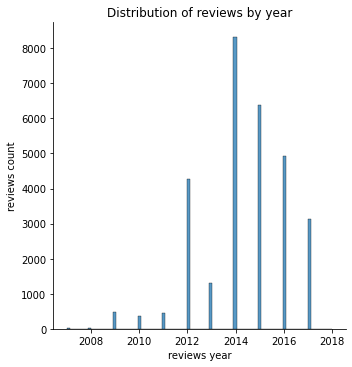

In [ ]:
# Create a distribution plot based on reviews year 
sns.displot(data=df_clean, x=df_clean.reviews_date.dt.year).set(title="Distribution of reviews by year", xlabel="reviews year", ylabel="reviews count")
plt.show()

## Check Product Categories by rating

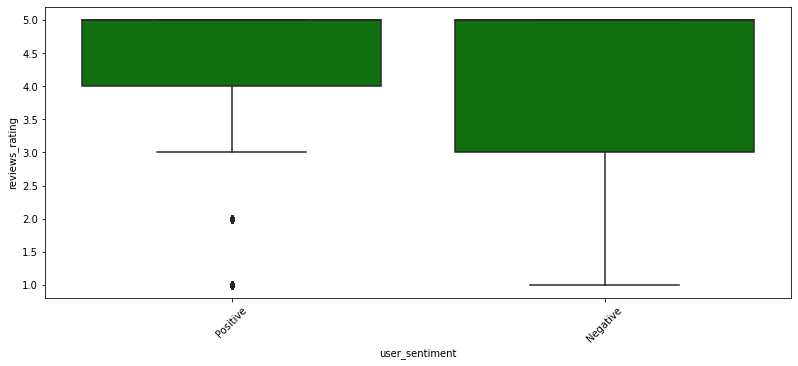

In [56]:
plt.figure(figsize = [12,6])

sns.boxplot(data=df_clean, x='user_sentiment', y='reviews_rating', color='green')
plt.xticks(rotation = 45)

plt.tight_layout(pad = 4)
plt.show()

In [57]:
df_clean[ (df_clean.user_sentiment == 'Negative') & (df_clean.reviews_rating >= 4) ].groupby(['reviews_rating']).count().user_sentiment

reviews_rating
4     548
5    1848
Name: user_sentiment, dtype: int64

2396 records with Negative Sentiment but rating >= 5, THis is contradictory. For this usecase ignoring it.

In [58]:
# Convert all the text columns to string for performing text operations
df_clean['brand'] = df_clean['brand'].astype(str)
df_clean['categories'] = df_clean['categories'].astype(str)
df_clean['manufacturer'] = df_clean['manufacturer'].astype(str)
df_clean['name'] = df_clean['name'].astype(str)
df_clean['reviews_text'] = df_clean['reviews_text'].astype(str)
df_clean['reviews_title'] = df_clean['reviews_title'].astype(str)
df_clean['reviews_username'] = df_clean['reviews_username'].astype(str)

# PreProcessing Step

In [59]:
# Get a copy of dataframe for pre-processing
df_prep = df_clean.copy()

In [60]:
# Combine reviews_text and reviews_title
df_prep['reviews_combined'] = df_prep['reviews_text'] + " " + df_prep['reviews_title']
df_prep.drop(columns=['reviews_text', 'reviews_title'], inplace=True)

In [61]:
df_prep.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_username,user_sentiment,reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5,joshua,Positive,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,dorothy w,Positive,Good flavor. This review was collected as part...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,dorothy w,Positive,Good flavor. Good
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00+00:00,1,rebecca,Negative,I read through the reviews on here before look...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00+00:00,1,walker557,Negative,My husband bought this gel for us. The gel cau...


In [62]:
# Remove unnecesary columns
df_prep.drop(columns=['categories', 'manufacturer', 'reviews_date'], inplace=True)

In [63]:
df_prep.head()

,id,brand,name,reviews_rating,reviews_username,user_sentiment,reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good flavor. This review was collected as part...
2,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good flavor. Good
3,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,I read through the reviews on here before look...
4,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,My husband bought this gel for us. The gel cau...


# Prepare Data for Sentiment Analysis

In [64]:
df_sent = df_prep[['id','name','reviews_combined', 'user_sentiment']]

In [65]:
df_sent.head()

,id,name,reviews_combined,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. Good,Positive
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,Negative
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,Negative


In [66]:
df_sent.shape

(29748, 4)

# Handle Punctuations

In [67]:
# Function to clean the text and remove all the unnecessary elements.
def clean_punctuation(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent)
    return sent

In [68]:
df_sent['reviews_cleaned'] = df_sent['reviews_combined'].apply(clean_punctuation)

In [69]:
df_sent.head(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive,i love this album its very good more to the hi...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive,good flavor this review was collected as part ...


#Handle Stopwords

In [70]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words("english"))
print(stopwords_set)

{'they', 'doesn', 'theirs', 'hers', "won't", 'a', 'all', 'm', 't', 'during', 'very', 'them', 'it', 'will', 'these', 'their', 'about', 'couldn', 'having', 'wasn', 'themselves', 'as', 'had', "shan't", 'those', 'd', 'then', 'were', 'over', 'before', 'don', 'ain', "couldn't", "mightn't", "wouldn't", "it's", 'whom', "hadn't", 'been', 'both', 's', 'll', 'with', 'was', 'off', 'further', 'any', 'between', 'you', 'yourselves', 'he', 'only', 'hadn', "you'll", "didn't", 'herself', 'in', 'nor', 'isn', 'against', 'won', 'being', 'by', 'there', 'ours', "you've", 'her', 'where', 'needn', 'she', 'that', 'now', 'y', "isn't", "haven't", "you're", 'once', "doesn't", 'its', 'than', 'shouldn', 'does', 'of', 'while', 'has', 'until', 'other', 'myself', 'again', 'when', 'why', 'at', 'hasn', "hasn't", 'after', "aren't", 'for', 'aren', 'each', 'own', 'or', 'through', 'out', "weren't", 'mightn', "you'd", 'no', 'should', 'ourselves', 'wouldn', 'we', 'can', 'have', 'an', 'but', 're', 'haven', 'too', 'didn', 'here'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [71]:
# Function to remove the stopwords
def clean_stopwords(sent):
    sent = sent.lower() # Text to lowercase
    words = word_tokenize(sent) # Split sentences into words
    text_nostopwords = " ".join( [each_word for each_word in words if each_word not in stopwords_set] )
    #return sent
    return text_nostopwords

In [72]:
df_sent['reviews_cleaned'] = df_sent['reviews_cleaned'].apply(clean_stopwords)

In [73]:
df_sent.head(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive,love album good hip hop side current pop sound...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive,good flavor review collected part promotion good


# Handle Lemmatization

In [74]:
# Function to lemmatize the text
def clean_lemma(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [75]:
df_sent['reviews_lemmatized'] = df_sent['reviews_cleaned'].apply(clean_lemma)

In [76]:
df_sent = df_sent[['id','name','reviews_lemmatized', 'user_sentiment']]
df_sent.head(2)

,id,name,reviews_lemmatized,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),love album good hip hop side current pop sound...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor review collect part promotion good,Positive


Save the clean Data

In [79]:
# Save the cleaned dataframe
pickle.dump(df_sent, open("/content/gdrive/My Drive/Colab/Capstone/models/clean_data.pkl","wb"))

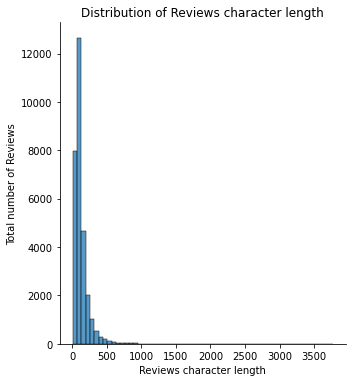

In [80]:
# Visualize 'reviews_lemmatized' character length
character_length = [len(each_sent) for each_sent in df_sent['reviews_lemmatized']]

sns.displot(character_length, kind='hist', bins=60)
plt.xlabel("Reviews character length")
plt.ylabel("Total number of Reviews")
plt.title("Distribution of Reviews character length")
plt.show()

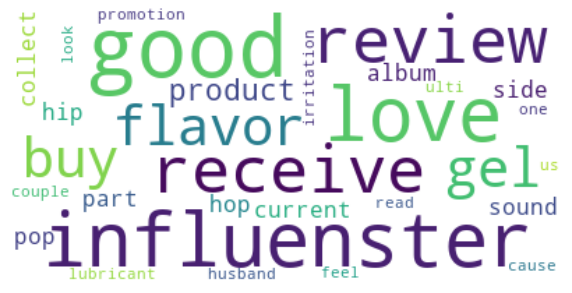

In [81]:
# Use a word cloud visualize the top 30 words in review by frequency
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=42, 
                      stopwords=stopwords_wordcloud).generate(str(df_sent['reviews_lemmatized']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#Feature Extraction

Here, we will perform,

Feature Extraction using TF-IDF. Check for and handle Class imbalance Perform train, test split


## TF-IDF Feature Extraction

Feature Extraction using TF-IDF convert the raw texts to a matrix of TF-IDF features

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

min_df is used for removing terms that appear too infrequently min_df = 5 means "ignore terms that appear in less than 5 complaints"


In [82]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [83]:
X = tfidf.fit_transform(df_sent['reviews_lemmatized'])

y= df_sent['user_sentiment']

In [84]:
# Save the tfidf vectorizer model
pickle.dump(tfidf, open("/content/gdrive/My Drive/Colab/Capstone/models/tfidf.pkl","wb"))

#Train, Test Split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [86]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (22311, 15935) (22311,)
Test shapes: (7437, 15935) (7437,)


## Class Imbalance

In [87]:
# Check the data to for class imbalance
df_sent['user_sentiment'].value_counts(normalize=True)

Positive    0.887892
Negative    0.112108
Name: user_sentiment, dtype: float64

Its Highly imbalanced, Lets use SMOTE to handle the imbalance

In [88]:
counter = Counter(y_train)
print("Before handling imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After handling imbalance", counter)

Before handling imbalance Counter({'Positive': 19786, 'Negative': 2525})
After handling imbalance Counter({'Positive': 19786, 'Negative': 19786})


# Model Building
Lets create the following three ML models based on performance for predicting the sentiments based on the text and title of the reviews:

    Logistic Regression
    Random Forest
    XGBoost



In [89]:
# Function to display scores
def evaluation_scores(classifier, X_test, y_test):

  # Calculating Predicted value
  y_pred = classifier.predict(X_test)

  # Create confusion matrix
  conf_m = confusion_matrix(y_test, y_pred)

  print("Visualizing the Confusion Matrix with a Heatmap")
  print("\n")
  print("*"*50)
  # Visualize Confusion Matrix with heatmap
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
  plt.xlabel("Actual label")
  plt.ylabel("Predicted label")
  plt.show()
  print("*"*50)
  print("\n")

  # Calculating the values of True Positives, True Negatives, False Positivies and False Negatives
  TP = conf_m[1][1]
  TN = conf_m[0][0]
  FP = conf_m[0][1]
  FN = conf_m[1][0]

  print("Values of True Positives, True Negatives, False Positivies and False Negatives")
  print("~"*50)
  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print("~"*50)
  print("\n")

  # Calculating Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy,2)
  
  # Calculating Sensitivity/Recall
  sensitivity_recall = (TP / float(TP + FN))
  sensitivity_recall = round(sensitivity_recall,2)
  
  # Calculating Specificity
  specificity = (TN / float(TN + FP))
  specificity = round(specificity,2)  
  
  # Calculating Precision
  precision = (TN / float(TN + FP))
  precision = round(precision,2)  
  
  # Calculating F_1 score
  F1_score = 2 * ((precision * sensitivity_recall) / (precision + sensitivity_recall))
  F1_score = round(F1_score,2)  
  
  print("Evaluation Score Summary")
  print('-'*50)
  print(f'Accuracy Score: {round(accuracy,2)}')
  print(f'Sensitivity/Recall Score: {round(sensitivity_recall,2)}') 
  print(f'Specificity Score: {round(specificity,2)}') 
  print(f'Precision: {round(precision,2)}')
  print(f'F1 Score: {round(F1_score,2)}')
  print('-'*50)

  # Returning evaluation results for comparison later
  evaluation_metrics = []
  evaluation_metrics.append(accuracy)
  evaluation_metrics.append(sensitivity_recall)
  evaluation_metrics.append(specificity)
  evaluation_metrics.append(precision)
  evaluation_metrics.append(F1_score)
  
  return evaluation_metrics

# Logistic Regression

In [90]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


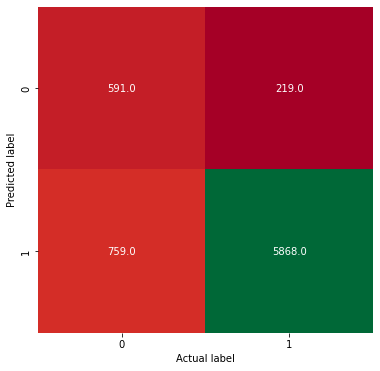

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 5868
True Negatives: 591
False Positives: 219
False Negatives: 759
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.87
Sensitivity/Recall Score: 0.89
Specificity Score: 0.73
Precision: 0.73
F1 Score: 0.8
--------------------------------------------------


In [91]:
# Get the score of the base model
lr_metrics = evaluation_scores(logreg, X_test, y_test)

In [92]:
# Print the scores of the base model as reference
df_lrb_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'Logistic Regression Base Model': lr_metrics},
                             columns = ['Metrics', 'Logistic Regression Base Model']
                             )
df_lrb_metrics

,Metrics,Logistic Regression Base Model
0,Accuracy,0.87
1,Sensitivity/Recall,0.89
2,Specificity,0.73
3,Precision,0.73
4,F1 Score,0.80


## Hyperparameter Tuning


In [93]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [94]:
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
logreg_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [95]:
# Check the best parameters
logreg_hpt.best_params_

{'C': 100, 'solver': 'liblinear'}

#HyperParameter Tuned Model

Visualizing the Confusion Matrix with a Heatmap


**************************************************


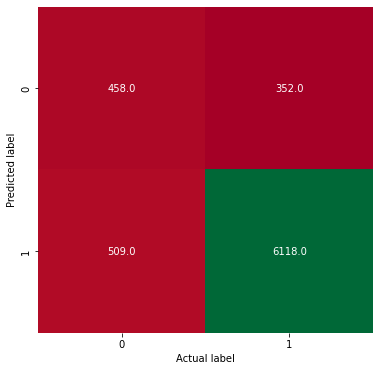

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6118
True Negatives: 458
False Positives: 352
False Negatives: 509
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.88
Sensitivity/Recall Score: 0.92
Specificity Score: 0.57
Precision: 0.57
F1 Score: 0.7
--------------------------------------------------


In [96]:
# Get the scores of the tuned model
lr_tuned_metrics = evaluation_scores(logreg_hpt, X_test, y_test)

In [97]:
# Print the scores of the base and tuned Logistic Regression model for reference
dict_lr_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'LR Base Model': lr_metrics,
                               'LR Tuned Model': lr_tuned_metrics}

df_lr_bt_metrics = pd.DataFrame(dict_lr_bt_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model'])
df_lr_bt_metrics

,Metrics,LR Base Model,LR Tuned Model
0,Accuracy,0.87,0.88
1,Sensitivity/Recall,0.89,0.92
2,Specificity,0.73,0.57
3,Precision,0.73,0.57
4,F1 Score,0.80,0.70


In [99]:
lr_base_model = pickle.dump(logreg, open('/content/gdrive/My Drive/Colab/Capstone/pickle/lr_base_model.pkl', 'wb'))
lr_tuned_model = pickle.dump(logreg_hpt, open('/content/gdrive/My Drive/Colab/Capstone/pickle/lr_tuned_model.pkl', 'wb'))

###Conclusion:

    For Logistic Regression, Base Model is performing better than the tuned model.
    We will consider the Base Model for evaluation purpose when we are doing model comparison.



# Random Forest Classifier

In [100]:
rf = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)

##Base Model

Visualizing the Confusion Matrix with a Heatmap


**************************************************


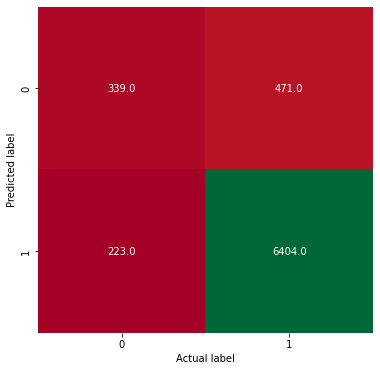

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6404
True Negatives: 339
False Positives: 471
False Negatives: 223
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.91
Sensitivity/Recall Score: 0.97
Specificity Score: 0.42
Precision: 0.42
F1 Score: 0.59
--------------------------------------------------


In [101]:
# Get the score of the base model
rf_metrics = evaluation_scores(rf, X_test, y_test)

###HyperParameter Tuning

In [102]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

In [103]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [104]:
# Check the best parameters
rf_hpt.best_params_

{'n_estimators': 810,
 'min_samples_split': 405,
 'min_samples_leaf': 45,
 'max_depth': 25}

Visualizing the Confusion Matrix with a Heatmap


**************************************************


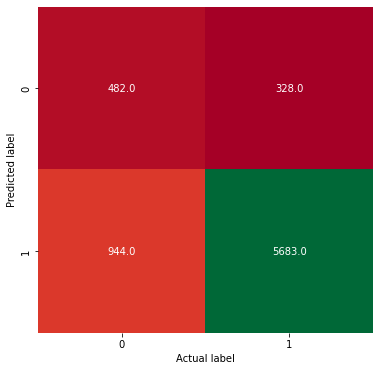

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 5683
True Negatives: 482
False Positives: 328
False Negatives: 944
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.83
Sensitivity/Recall Score: 0.86
Specificity Score: 0.6
Precision: 0.6
F1 Score: 0.71
--------------------------------------------------


[0.83, 0.86, 0.6, 0.6, 0.71]

In [105]:
evaluation_scores(rf_hpt, X_test, y_test)

Sensitivity, Precision and F1 Score have improved a little bit with Random Search CV. We will strive to improve this further by doing fine hyperparameter tuning using Grid Search CV.

In [106]:
# Fine tuning using Grid Search CV
rf_grid = {"n_estimators": [510],
           "max_depth": [20],
           "min_samples_split": [350, 400],
           "min_samples_leaf": [45, 50]}

In [107]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


### HyperParameter tuned model

Visualizing the Confusion Matrix with a Heatmap


**************************************************


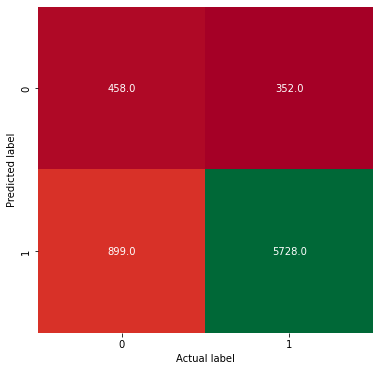

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 5728
True Negatives: 458
False Positives: 352
False Negatives: 899
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.83
Sensitivity/Recall Score: 0.86
Specificity Score: 0.57
Precision: 0.57
F1 Score: 0.69
--------------------------------------------------


In [108]:
# Get the scores of the tuned model
rf_tuned_metrics = evaluation_scores(rf_hpt, X_test, y_test)

In [109]:
# Print the scores of the base and tuned Random Forest model as reference
dict_rf_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'RF Base Model': rf_metrics,
                               'RF Tuned Model': rf_tuned_metrics}

df_rf_bt_metrics = pd.DataFrame(dict_rf_bt_metrics, columns = ['Metrics', 'RF Base Model', 'RF Tuned Model'])
df_rf_bt_metrics

,Metrics,RF Base Model,RF Tuned Model
0,Accuracy,0.91,0.83
1,Sensitivity/Recall,0.97,0.86
2,Specificity,0.42,0.57
3,Precision,0.42,0.57
4,F1 Score,0.59,0.69


In [110]:
rf_base_model = pickle.dump(rf, open('/content/gdrive/My Drive/Colab/Capstone/pickle/rf_base_model.pkl', 'wb'))
rf_tuned_model = pickle.dump(rf_hpt, open('/content/gdrive/My Drive/Colab/Capstone/pickle/rf_tuned_model.pkl', 'wb'))

###Conclusion:

For Random Forest, Tuned Model is performing better than the base model as F1 Score is better. We will consider the Tuned Model for evaluation purpose when we are doing model comparison.


#XGBoost Classifier

In [111]:
xg = xgb.XGBClassifier(random_state=42).fit(X_train_sm, y_train_sm)

##Base Model

Visualizing the Confusion Matrix with a Heatmap


**************************************************


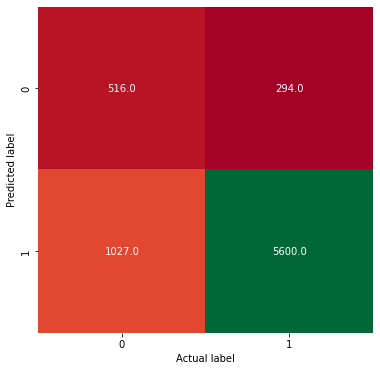

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 5600
True Negatives: 516
False Positives: 294
False Negatives: 1027
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.82
Sensitivity/Recall Score: 0.85
Specificity Score: 0.64
Precision: 0.64
F1 Score: 0.73
--------------------------------------------------


In [112]:
# Get the score of the base model
xg_metrics = evaluation_scores(xg, X_test, y_test)

In [113]:
# Print the scores of the base model as reference
df_xgb_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'XG Base Model': xg_metrics},
                             columns = ['Metrics', 'XG Base Model']
                             )
df_xgb_metrics

,Metrics,XG Base Model
0,Accuracy,0.82
1,Sensitivity/Recall,0.85
2,Specificity,0.64
3,Precision,0.64
4,F1 Score,0.73


##HyperParameter Tuning

In [114]:
xg_grid = {"learning_rate": np.arange(0.05, 1, 0.1),
           "max_depth": np.arange(5, 20, 5)
           }

In [115]:
# Setup random hyperparameter search for XGBoost Classifier
xg_hpt = RandomizedSearchCV(XGBClassifier(random_state=42),
                                param_distributions=xg_grid,
                                cv=4,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_train_sm);

Fitting 4 folds for each of 10 candidates, totalling 40 fits


In [116]:
# Check the best parameters
xg_hpt.best_params_

{'max_depth': 5, 'learning_rate': 0.45000000000000007}

Visualizing the Confusion Matrix with a Heatmap


**************************************************


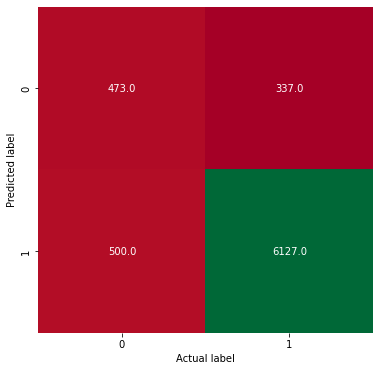

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6127
True Negatives: 473
False Positives: 337
False Negatives: 500
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.89
Sensitivity/Recall Score: 0.92
Specificity Score: 0.58
Precision: 0.58
F1 Score: 0.71
--------------------------------------------------


[0.89, 0.92, 0.58, 0.58, 0.71]

In [117]:
evaluation_scores(xg_hpt, X_test, y_test)

In [118]:
# Fine tuning with Grid Search CV
xg_grid = {"learning_rate": [0.45, 0.15],
           "max_depth": [5, 10]
           }

In [119]:
# Setup random hyperparameter search for XGBoost Classifier
xg_hpt = GridSearchCV(XGBClassifier(random_state=42),
                                param_grid=xg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [120]:
# Check the best parameters
xg_hpt.best_params_

{'learning_rate': 0.45, 'max_depth': 5}

##HyperParameter tuned model

Visualizing the Confusion Matrix with a Heatmap


**************************************************


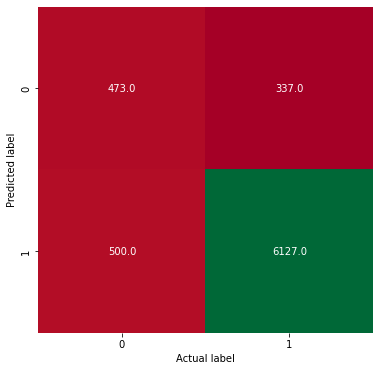

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6127
True Negatives: 473
False Positives: 337
False Negatives: 500
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.89
Sensitivity/Recall Score: 0.92
Specificity Score: 0.58
Precision: 0.58
F1 Score: 0.71
--------------------------------------------------


In [121]:
# Get the scores of the tuned model
xg_tuned_metrics = evaluation_scores(xg_hpt, X_test, y_test)

In [122]:
# Print the scores of the base and tuned XGBoost model as reference
dict_xg_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'XG Base Model': xg_metrics,
                               'XG Tuned Model': xg_tuned_metrics}

df_xg_bt_metrics = pd.DataFrame(dict_xg_bt_metrics, columns = ['Metrics', 'XG Base Model', 'XG Tuned Model'])
df_xg_bt_metrics

,Metrics,XG Base Model,XG Tuned Model
0,Accuracy,0.82,0.89
1,Sensitivity/Recall,0.85,0.92
2,Specificity,0.64,0.58
3,Precision,0.64,0.58
4,F1 Score,0.73,0.71


In [123]:
xg_base_model = pickle.dump(xg, open('/content/gdrive/My Drive/Colab/Capstone/pickle/xg_base_model.pkl', 'wb'))
xg_tuned_model = pickle.dump(xg_hpt, open('/content/gdrive/My Drive/Colab/Capstone/pickle/xg_tuned_model.pkl', 'wb'))

####Conclusion:

    For XG Boost model, Base Model is performing better than the tuned model.
    We will consider the Base Model for evaluation purpose when we are doing model comparison.



##Model Evaluation

In [124]:
# Print the scores of all the 3 Models (Base and Tuned)
dict_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'],
                              'LR Base Model': lr_metrics, 'LR Tuned Model': lr_tuned_metrics,
                              'RF Base Model': rf_metrics, 'RF Tuned Model': rf_tuned_metrics,
                              'XG Base Model': xg_metrics, 'XG Tuned Model': xg_tuned_metrics}

df_bt_metrics = pd.DataFrame(dict_bt_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model', 'RF Base Model', 'RF Tuned Model', 'XG Base Model', 'XG Tuned Model'])
df_bt_metrics

,Metrics,LR Base Model,LR Tuned Model,RF Base Model,RF Tuned Model,XG Base Model,XG Tuned Model
0,Accuracy,0.87,0.88,0.91,0.83,0.82,0.89
1,Sensitivity/Recall,0.89,0.92,0.97,0.86,0.85,0.92
2,Specificity,0.73,0.57,0.42,0.57,0.64,0.58
3,Precision,0.73,0.57,0.42,0.57,0.64,0.58
4,F1 Score,0.80,0.70,0.59,0.69,0.73,0.71


In [125]:
# Save the base logistic regression model as the best sentiment model for future use 
best_sentiment_model = pickle.dump(logreg, open('/content/gdrive/My Drive/Colab/Capstone/models/best_sentiment_model.pkl', 'wb'))

Looking at the model evaluation metrics and focusing on Sensitivity, Specificity and F1 Score, we can conclude that the base Logistic Regression Model is the best model out of all of them.

#Building a Recommendation System

We will build the below two recommendation systems

    User-based recommendation system
    Item-based recommendation system

Once built, we will analyze the recommendation systems and select the one that is best suited in this case. Once we get the best-suited recommendation system, the next task will be to recommend 20 products that a user is most likely to purchase based on the ratings.


In [126]:
df_reco = pd.read_csv('/content/gdrive/My Drive/Colab/Capstone/sample30.csv')

In [127]:
df_reco.shape

(30000, 15)

In [128]:
# We need only the below columns for building a recommendation system
df_reco = df_reco[["id", "name", "reviews_rating", "reviews_username"]]

In [129]:
df_reco.shape

(30000, 4)

In [130]:
df_reco.head()

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


##Handling NULL values

In [131]:
# Get total number of NULL values and percentage of the columns
null_count = df_reco[df_reco.columns[df_reco.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_reco[df_reco.columns[df_reco.isna().any()]].isna().sum() * 100 / df_reco.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

,Count,Percentage
reviews_username,63,0.21


In [132]:
# Remove the rows where reviews_username is NULL
df_reco = df_reco[~ df_reco.reviews_username.isna() ]

In [133]:
# Get total number of NULL values and percentage of the columns
null_count = df_reco[df_reco.columns[df_reco.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_reco[df_reco.columns[df_reco.isna().any()]].isna().sum() * 100 / df_reco.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

,Count,Percentage


## Train, Test Split

In [134]:
train, test = train_test_split(df_reco, test_size=0.30, random_state=42)
print(train.shape)
print(test.shape)

(20955, 4)
(8982, 4)


In [135]:
train.head(2)

,id,name,reviews_rating,reviews_username
962,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,5,brittney w
10463,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,cjshrad


In [136]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Create dummy train & dummy test dataset

    Dummy train will be used later for prediction of the products which have not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.
    Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.



In [138]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [139]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [140]:
# Convert the dummy train dataset into matrix format
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

dummy_train.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [141]:
dummy_train.head(2)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is reviews_rating in this case]

Adjusted Cosine

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.


##User Similarity Matrix (Using Adjusted Cosine)
Here let us not remove the NaN values and calculate the mean only for the products rated by the user

In [142]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [143]:
# For verification purpose, we do have cases where the rating is not NaN
df_pivot[~df_pivot['AV13O1A8GV-KLJ3akUyj'].isna()]

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
joshua,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Normalize the rating of the product for each user around 0 mean

In [144]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [145]:
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Find cosine similarity

In [146]:
# Create the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [147]:
user_correlation.shape

(18275, 18275)

**Prediction - User User**

Lets do prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, we will ignore the correlation for values less than 0.


In [148]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [149]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 2.5       , ..., 1.46525748, 1.88982237,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [150]:
user_predicted_ratings.shape

(18275, 256)

As we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.

In [151]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,2.5,3.596262,0.0,0.0,0.0,0.0,2.581989,1.018079,...,1.666667,0.188982,0.0,0.0,0.0,0.0,0.0,1.465257,1.889822,0.204124
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


##Find the Top 20 products that a user is most likely to purchase based on the ratings (user-user based recommendation)

In [152]:
# Take a sample username as input.
user_input = '00sab00'

In [153]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

,Product Id,cosine_similarity_score
0,AVpfPaoqLJeJML435Xk9,37.472929
1,AVpfRTh1ilAPnD_xYic2,29.191053
2,AVpf0eb2LJeJML43EVSt,14.259486
3,AVpf3VOfilAPnD_xjpun,12.313738
4,AVpf2tw1ilAPnD_xjflC,11.178377
5,AVpfBrUZilAPnD_xTUly,7.831663
6,AVpfov9TLJeJML43A7B0,6.623441
7,AVpf385g1cnluZ0-s0_t,6.253560
8,AVpfM_ytilAPnD_xXIJb,6.154565
9,AVpfR5m0LJeJML436K3W,5.650706


In [154]:
top20_rec = pd.merge(df_reco, df_top20_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
16,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,37.472929
19,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,29.191053
2,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),14.259486
6,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,12.313738
4,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),11.178377
9,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Co...",7.831663
15,AVpfov9TLJeJML43A7B0,Bisquick Original Pancake And Baking Mix - 40oz,6.623441
5,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",6.253560
11,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,6.154565
18,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,5.650706


**Evaluation - User User**

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.


In [155]:
train.head(2)

,id,name,reviews_rating,reviews_username
962,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,5,brittney w
10463,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,cjshrad


In [156]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2051, 4)

In [157]:
common.head(2)

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica
21657,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318


In [158]:
# Lets convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [159]:
common_user_based_matrix.head(2)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
# Lets convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [161]:
user_correlation_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
df_subtracted.head(1)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274
userId,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
common.head(1)

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica


In [165]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [166]:
user_correlation_df_1.shape

(1693, 18275)

In [167]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T

In [168]:
user_correlation_df_3.head()

,1234,1234567,123charlie,1943,1witch,4 rooms 1 dog lotsa fur,85lisa,a hutch,aac06002,aalyah,...,xavier,yamel97,yayawomack,yorkielvr,yummy,yvonne,zach,zebras,zippy,zxcsdfd
userId,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
user_correlation_df_3.shape

(1693, 1693)

In [170]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [171]:
common.head(2)

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica
21657,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318


In [172]:
# Create dummy test dataframe
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [173]:
dummy_test.shape

(1693, 140)

In [174]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [175]:
common_user_predicted_ratings.head(2)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [177]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [178]:
# Find total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

RMSE (Root Mean Square Error) for User-User recommendation system

In [179]:
rmse_user_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

2.551419404666111


##Using Item Similarity

###Item Based Similarity

Here we take the transpose of the rating matrix to normalize the rating around the mean for different Product ID. In the user based similarity, we had taken mean for each user instead of each product.


In [180]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

In [181]:
df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [183]:
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [185]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Prediction - Item Item

In [186]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00603917, 0.06485571,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0094556 ],
       [0.        , 0.        , 0.        , ..., 0.00781596, 0.10809285,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756448]])

In [187]:
item_predicted_ratings.shape

(18275, 256)

In [188]:
dummy_train.shape

(18275, 256)

Filter the rating only for the products not rated by the user for recommendation

In [189]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.006042,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.020509,0.006039,0.064856,0.000000
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.097645,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.162741,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.130193,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
0325home,0.0,0.0,0.0,0.000082,0.0,0.0,0.0,0.001244,0.002197,0.001808,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.006084,0.000000,0.000000,0.009456


In [190]:
# Take a sample username as input.
user_input = '00sab00'

In [191]:
top20_item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_item_recommendations = pd.DataFrame({'Product Id': top20_item_recommendations.index, 'cosine_similarity_score' : top20_item_recommendations})
df_top20_item_recommendations.reset_index(drop=True, inplace=True)
df_top20_item_recommendations

,Product Id,cosine_similarity_score
0,AVpfE7puilAPnD_xUcCW,0.147125
1,AVpfv4TlilAPnD_xhjNS,0.064856
2,AVpfJcHuLJeJML433ZrY,0.052161
3,AVpf0thK1cnluZ0-r8vR,0.036554
4,AVpe6PCDLJeJML43yFQH,0.032108
5,AVpe_dxlilAPnD_xSiHI,0.030764
6,AVpfQtEm1cnluZ0-hUpe,0.027387
7,AVpfHf4wLJeJML432vqK,0.022930
8,AVpfthSailAPnD_xg3ON,0.020509
9,AVpe6FfKilAPnD_xQmHi,0.020308


**Find the Top 20 products that a user is most likely to purchase based on the ratings (item-item based recommendation)**

In [192]:
top20_item_rec = pd.merge(df_reco, df_top20_item_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_item_rec.reset_index(drop=True, inplace=True)
top20_item_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
11,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.147125
19,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter ...,0.064856
13,AVpfJcHuLJeJML433ZrY,Equals (blu-Ray),0.052161
8,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),0.036554
6,AVpe6PCDLJeJML43yFQH,Wagan Smartac 80watt Inverter With Usb,0.032108
0,AVpe_dxlilAPnD_xSiHI,"The Seaweed Bath Co. Argan Conditioner, Smooth...",0.030764
17,AVpfQtEm1cnluZ0-hUpe,Jolly Time Select Premium Yellow Pop Corn,0.027387
12,AVpfHf4wLJeJML432vqK,Trend Lab Park Nursing Cover - Paisley,0.022930
18,AVpfthSailAPnD_xg3ON,"Musselman Apple Sauce, Cinnamon, 48oz",0.020509
4,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,0.020308


**Evaluation - Item Item**
Evaluation will be same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.


In [193]:
test.columns

Index(['id', 'name', 'reviews_rating', 'reviews_username'], dtype='object')

In [194]:
# Find out the common products of test and train dataset.
common = test[test.id.isin(train.id)]
common.shape

(8966, 4)

In [195]:
common.head(2)

,id,name,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,ashleydale00


In [196]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [197]:
common_item_based_matrix.shape

(195, 8318)

In [198]:
item_correlation_df = pd.DataFrame(item_correlation)

In [199]:
item_correlation_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
item_correlation_df['movieId'] = df_subtracted.index
item_correlation_df.set_index('movieId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
movieId,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head(2)

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
movieId,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.108098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.34691174e-02, 3.00000000e+00, 6.62104097e-03, ...,
        0.00000000e+00, 5.16904870e-03, 8.22214474e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.45559849e-03]])

In [203]:
common_item_predicted_ratings.shape

(195, 8318)

In [204]:
common.head(2)

,id,name,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,ashleydale00


In [205]:
# We will use Dummy test for evaluation
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [206]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [207]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [208]:
# Find total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [209]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.5439427186448222


**Best-suited Recommendation model**

    To get the best recommendation model, we will use RMSE (Root Mean Square Error) scores for both user-user and item-item based recommendation systems and do a comparison of the values.
    The recommendation model with the least RMSE will be selected as the best recommendation model.



In [210]:
# Recommended model evaluation
if rmse_user_user < rmse_item_item:
  print("Best-fit model is user-user recommendation system")
else:
  print("Best-fit model is item-item recommendation system")

Best-fit model is user-user recommendation system


**Top 20 Product recommendations to the user by the best recommendation model (user-user based recommendation system)**

In [211]:
# Take a sample username as input
user_input = 'evrydayhustla420'

In [212]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

,Product Id,cosine_similarity_score
0,AVpfRTh1ilAPnD_xYic2,16.870920
1,AVpe41TqilAPnD_xQH3d,13.017496
2,AVpf0eb2LJeJML43EVSt,11.843501
3,AVpf3VOfilAPnD_xjpun,9.609059
4,AVpe59io1cnluZ0-ZgDU,7.706569
5,AVpfJP1C1cnluZ0-e3Xy,5.474655
6,AVpfOIrkilAPnD_xXgDG,4.809401
7,AVpfPnrU1cnluZ0-g9rL,4.539020
8,AVpe31o71cnluZ0-YrSD,4.336229
9,AVpe8gsILJeJML43y6Ed,4.309060


In [213]:
top20_rec = pd.merge(df_reco, df_top20_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
18,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,16.870920
1,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),13.017496
5,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),11.843501
8,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,9.609059
2,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,7.706569
12,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5.474655
15,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),4.809401
17,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's C...,4.539020
0,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultravio...,4.336229
3,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi S...",4.309060


##Save the best recommendation model

In [214]:
user_final_rating.shape

(18275, 256)

In [215]:
user_final_rating.head(2)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,2.5,3.596262,0.0,0.0,0.0,0.0,2.581989,1.018079,...,1.666667,0.188982,0.0,0.0,0.0,0.0,0.0,1.465257,1.889822,0.204124
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [216]:
best_recommendation_model = pickle.dump(user_final_rating.astype('float32'), open('/content/gdrive/My Drive/Colab/Capstone/models/best_recommendation_model.pkl', 'wb'))

**Fine-Tuning the Recommendation System and Recommendation of Top 5 Products**

In [217]:
# Create function to recommend top 5 products to any user
def product_recommendations_user(user_name):
  if user_name not in user_final_rating.index:
    print(f"The User {user_name} does not exist. Please provide a valid user name")
  else:
    # Get top 20 recommended products from the best recommendation model
    top20_recommended_products = list(user_final_rating.loc[user_name].sort_values(ascending=False)[0:20].index)
    # Get only the recommended products from the prepared dataframe "df_sent"
    df_top20_products = df_sent[df_sent.id.isin(top20_recommended_products)]
    # For these 20 products, get their user reviews and pass them through TF-IDF vectorizer to convert the data into suitable format for modeling
    X = tfidf.transform(df_top20_products["reviews_lemmatized"].values.astype(str))
    # Use the best sentiment model to predict the sentiment for these user reviews
    df_top20_products['predicted_sentiment'] = logreg.predict(X)
    # Create a new column to map Positive sentiment to 1 and Negative sentiment to 0. This will allow us to easily summarize the data
    df_top20_products['positive_sentiment'] = df_top20_products['predicted_sentiment'].apply(lambda x: 1 if x=="Positive" else 0)
    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    pred_df = df_top20_products.groupby(by='name').sum()
    pred_df.columns=['pos_sent_count']
    # Create a column to measure the total sentiment count
    pred_df['total_sent_count'] = df_top20_products.groupby(by='name')['predicted_sentiment'].count()
    # Create a column that measures the % of positive user sentiment for each product review
    pred_df['post_sent_percentage'] = np.round(pred_df['pos_sent_count']/pred_df['total_sent_count']*100,2)
    # Return top 5 recommended products to the user
    result = pred_df.sort_values(by='post_sent_percentage', ascending=False)[:5]
    return result

**Top 5 Products Recommendation**

In [220]:
# Take a sample username as input
#user_input = 'charlie'
#user_input ='Venkat'
user_input = 'debb'
# 'evrydayhustla420'
print(f"Printing the top 5 recommended products for the user: {user_input} along with each product's positive sentiment count, overall review count and positive sentiment %")
print("\n")
top5_reco_sent_reco_user = product_recommendations_user(user_input)
top5_reco_sent_reco_user

Printing the top 5 recommended products for the user: debb along with each product's positive sentiment count, overall review count and positive sentiment %




,pos_sent_count,total_sent_count,post_sent_percentage
name,,,
Reebok Classic Leather Running Shoes - White (Men),5,5,100.00
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),174,186,93.55
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),614,668,91.92
Clorox Disinfecting Bathroom Cleaner,1812,2039,88.87
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1003,1140,87.98


In [221]:
# Showing only the top 5 Product Names for the user
print(f"Printing the top 5 recommended products list for the user: {user_input}")
print(list(top5_reco_sent_reco_user.index))

Printing the top 5 recommended products list for the user: debb
['Reebok Classic Leather Running Shoes - White (Men)', "Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)", 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)', 'Clorox Disinfecting Bathroom Cleaner', 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)']


### Deployment and code link

Heroku Deplyment Link: https://sabarna-upgrad-capstone.herokuapp.com/                                                          

Git Link: https://github.com/psabarna/Capstone